<a href="https://colab.research.google.com/github/Kuliah-Machine-Learning/2021-Batik-Kel-1/blob/main/Batik_Classifier_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Kuliah-Machine-Learning/2021-Batik-Kel-1

Cloning into '2021-Batik-Kel-1'...
remote: Enumerating objects: 2867, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2867 (delta 0), reused 5 (delta 0), pack-reused 2855
Receiving objects: 100% (2867/2867), 45.08 MiB | 34.19 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
%cd 2021-Batik-Kel-1

/content/2021-Batik-Kel-1/2021-Batik-Kel-1


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls Data/
!ls Data/Train/Banji
!ls Data/Train/Kawung
!ls Data/Train/Parang
!ls Data/Train/Tumpal

Train  Validasi
B10.jpg  B1.jpg   B29.jpg  B38.jpg  B47.jpg  B56.jpg  B65.jpg  B74.jpg	B83.jpg
B11.jpg  B20.jpg  B2.jpg   B39.jpg  B48.jpg  B57.jpg  B66.jpg  B75.jpg	B84.jpg
B12.jpg  B21.jpg  B30.jpg  B3.jpg   B49.jpg  B58.jpg  B67.jpg  B76.jpg	B85.jpg
B13.jpg  B22.jpg  B31.jpg  B40.jpg  B4.jpg   B59.jpg  B68.jpg  B77.jpg	B86.jpg
B14.jpg  B23.jpg  B32.jpg  B41.jpg  B50.jpg  B5.jpg   B69.jpg  B78.jpg	B87.jpg
B15.jpg  B24.jpg  B33.jpg  B42.jpg  B51.jpg  B60.jpg  B6.jpg   B79.jpg	B88.jpg
B16.jpg  B25.jpg  B34.jpg  B43.jpg  B52.jpg  B61.jpg  B70.jpg  B7.jpg	B89.jpg
B17.jpg  B26.jpg  B35.jpg  B44.jpg  B53.jpg  B62.jpg  B71.jpg  B80.jpg	B8.jpg
B18.jpg  B27.jpg  B36.jpg  B45.jpg  B54.jpg  B63.jpg  B72.jpg  B81.jpg	B90.jpg
B19.jpg  B28.jpg  B37.jpg  B46.jpg  B55.jpg  B64.jpg  B73.jpg  B82.jpg	B9.jpg
K100.jpg  K118.jpg  K135.jpg  K15.jpg  K32.jpg	K4.jpg	 K67.jpg  K85.jpg
K101.jpg  K119.jpg  K136.jpg  K16.jpg  K33.jpg	K50.jpg  K68.jpg  K86.jpg
K102.jpg  K11.jpg   K137.jpg  K17.jpg  K34.jpg	K51.j

In [ ]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 200
BATCH_SIZE = 32
base_dir = os.path.join('Data/Train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Banji', 'Kawung', 'Parang', 'Tumpal']

for i,label in enumerate(labels):
    folder = os.path.join("Data/Validasi",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(200,200))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 394 images belonging to 4 classes.
Found 97 images belonging to 4 classes.
Bentuk array dari dataset train (pelatihan) adalah: (32, 200, 200, 3) (32, 4)
Bentuk array dari dataset validation (validasi) adalah: (32, 200, 200, 3) (32, 4)
Bentuk array dari dataset test (pengujian) adalah: (86, 200, 200, 3) (86,)


In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Banji': 0, 'Kawung': 1, 'Parang': 2, 'Tumpal': 3}


In [ ]:
!cat labels.txt

Banji
Kawung
Parang
Tumpal

In [ ]:
IMG_SHAPE = (200, 200, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,154,436
Trainable params: 9,439,748
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Epoch 1/50
13/13 [==============================] - 197s 15s/step - loss: 2.4612 - acc: 0.5102 - val_loss: 0.8779 - val_acc: 0.6804
Epoch 2/50
13/13 [==============================] - 195s 15s/step - loss: 0.4358 - acc: 0.8629 - val_loss: 0.5493 - val_acc: 0.8144
Epoch 3/50
13/13 [==============================] - 195s 15s/step - loss: 0.1830 - acc: 0.9492 - val_loss: 0.5610 - val_acc: 0.8041
Epoch 4/50
13/13 [==============================] - 195s 15s/step - loss: 0.0732 - acc: 0.9721 - val_loss: 0.3017 - val_acc: 0.8763
Epoch 5/50
13/13 [==============================] - 196s 15s/step - loss: 0.0337 - acc: 0.9924 - val_loss: 0.3313 - val_acc: 0.8866
Epoch 6/50
13/13 [==============================] - 194s 15s/step - loss: 0.0267 - acc: 0.9924 - val_loss: 0.4207 - val_acc: 0.8763
Epoch 7/50
13/13 [==============================] - 194s 15s/step - loss: 0.0334 - acc: 0.9873 - val_loss: 0.3084 - val_acc: 0.8454
Epoch 8/50
13/13 [==============================] - 195s 15s/step - loss: 0.

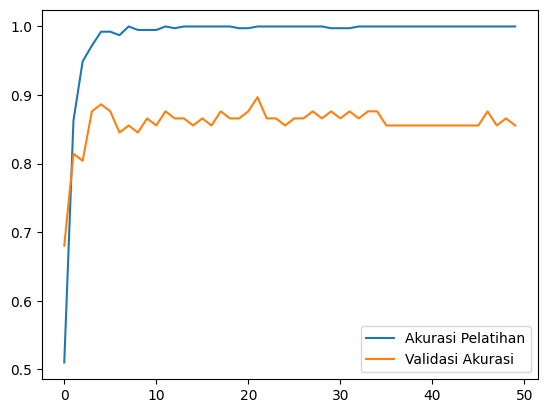

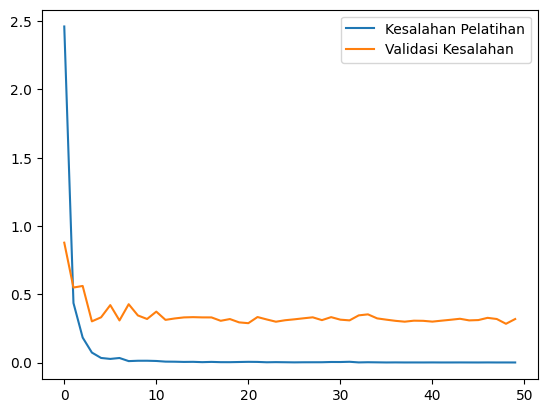

In [28]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [29]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [30]:
print(train_generator)

In [33]:
#Prediksi Label Validasi dengan Pelatihan
n = 10
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0. 0.]
Prediksinya adalah [5.1651132e-06 9.9990892e-01 5.4553664e-05 3.1352280e-05]


In [34]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
13/13 [==============================] - 156s 12s/step - loss: 2.5092e-04 - acc: 1.0000
[0.0002509203914087266, 1.0]
4/4 [==============================] - 38s 9s/step - loss: 0.3187 - acc: 0.8557
[0.3187476694583893, 0.8556700944900513]
3/3 [==============================] - 34s 11s/step - loss: 0.9550 - acc: 0.7907
[0.9550319910049438, 0.7906976938247681]


In [35]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]
[1 1 1 2 0 1 1 2 1 1 0 0 0 1 2 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 3 3 3 3 3 1 3 3 3
 3 1 3 3 2 3 3 3 3 3 3 3]


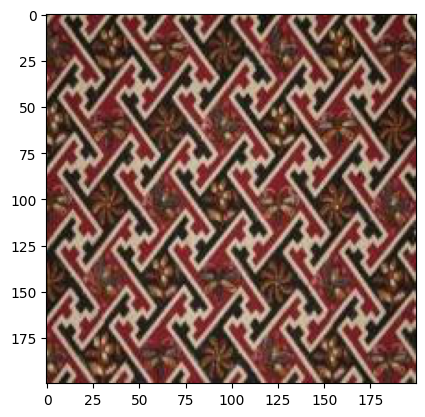

Label yang benar adalah: 0 : Banji
Nilai yang diprediksi adalah: [0.59345704 0.3560047  0.00724778 0.04329051]
Label yang diprediksi adalah: 0 : Banji
Prediksi benar


In [37]:
n = 10 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[0.32 0.47 0.16 0.05]
 [0.   1.   0.   0.  ]
 [0.   0.04 0.96 0.  ]
 [0.   0.08 0.08 0.84]]


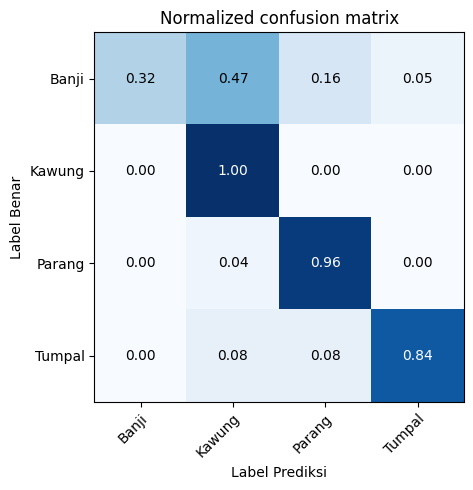

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')